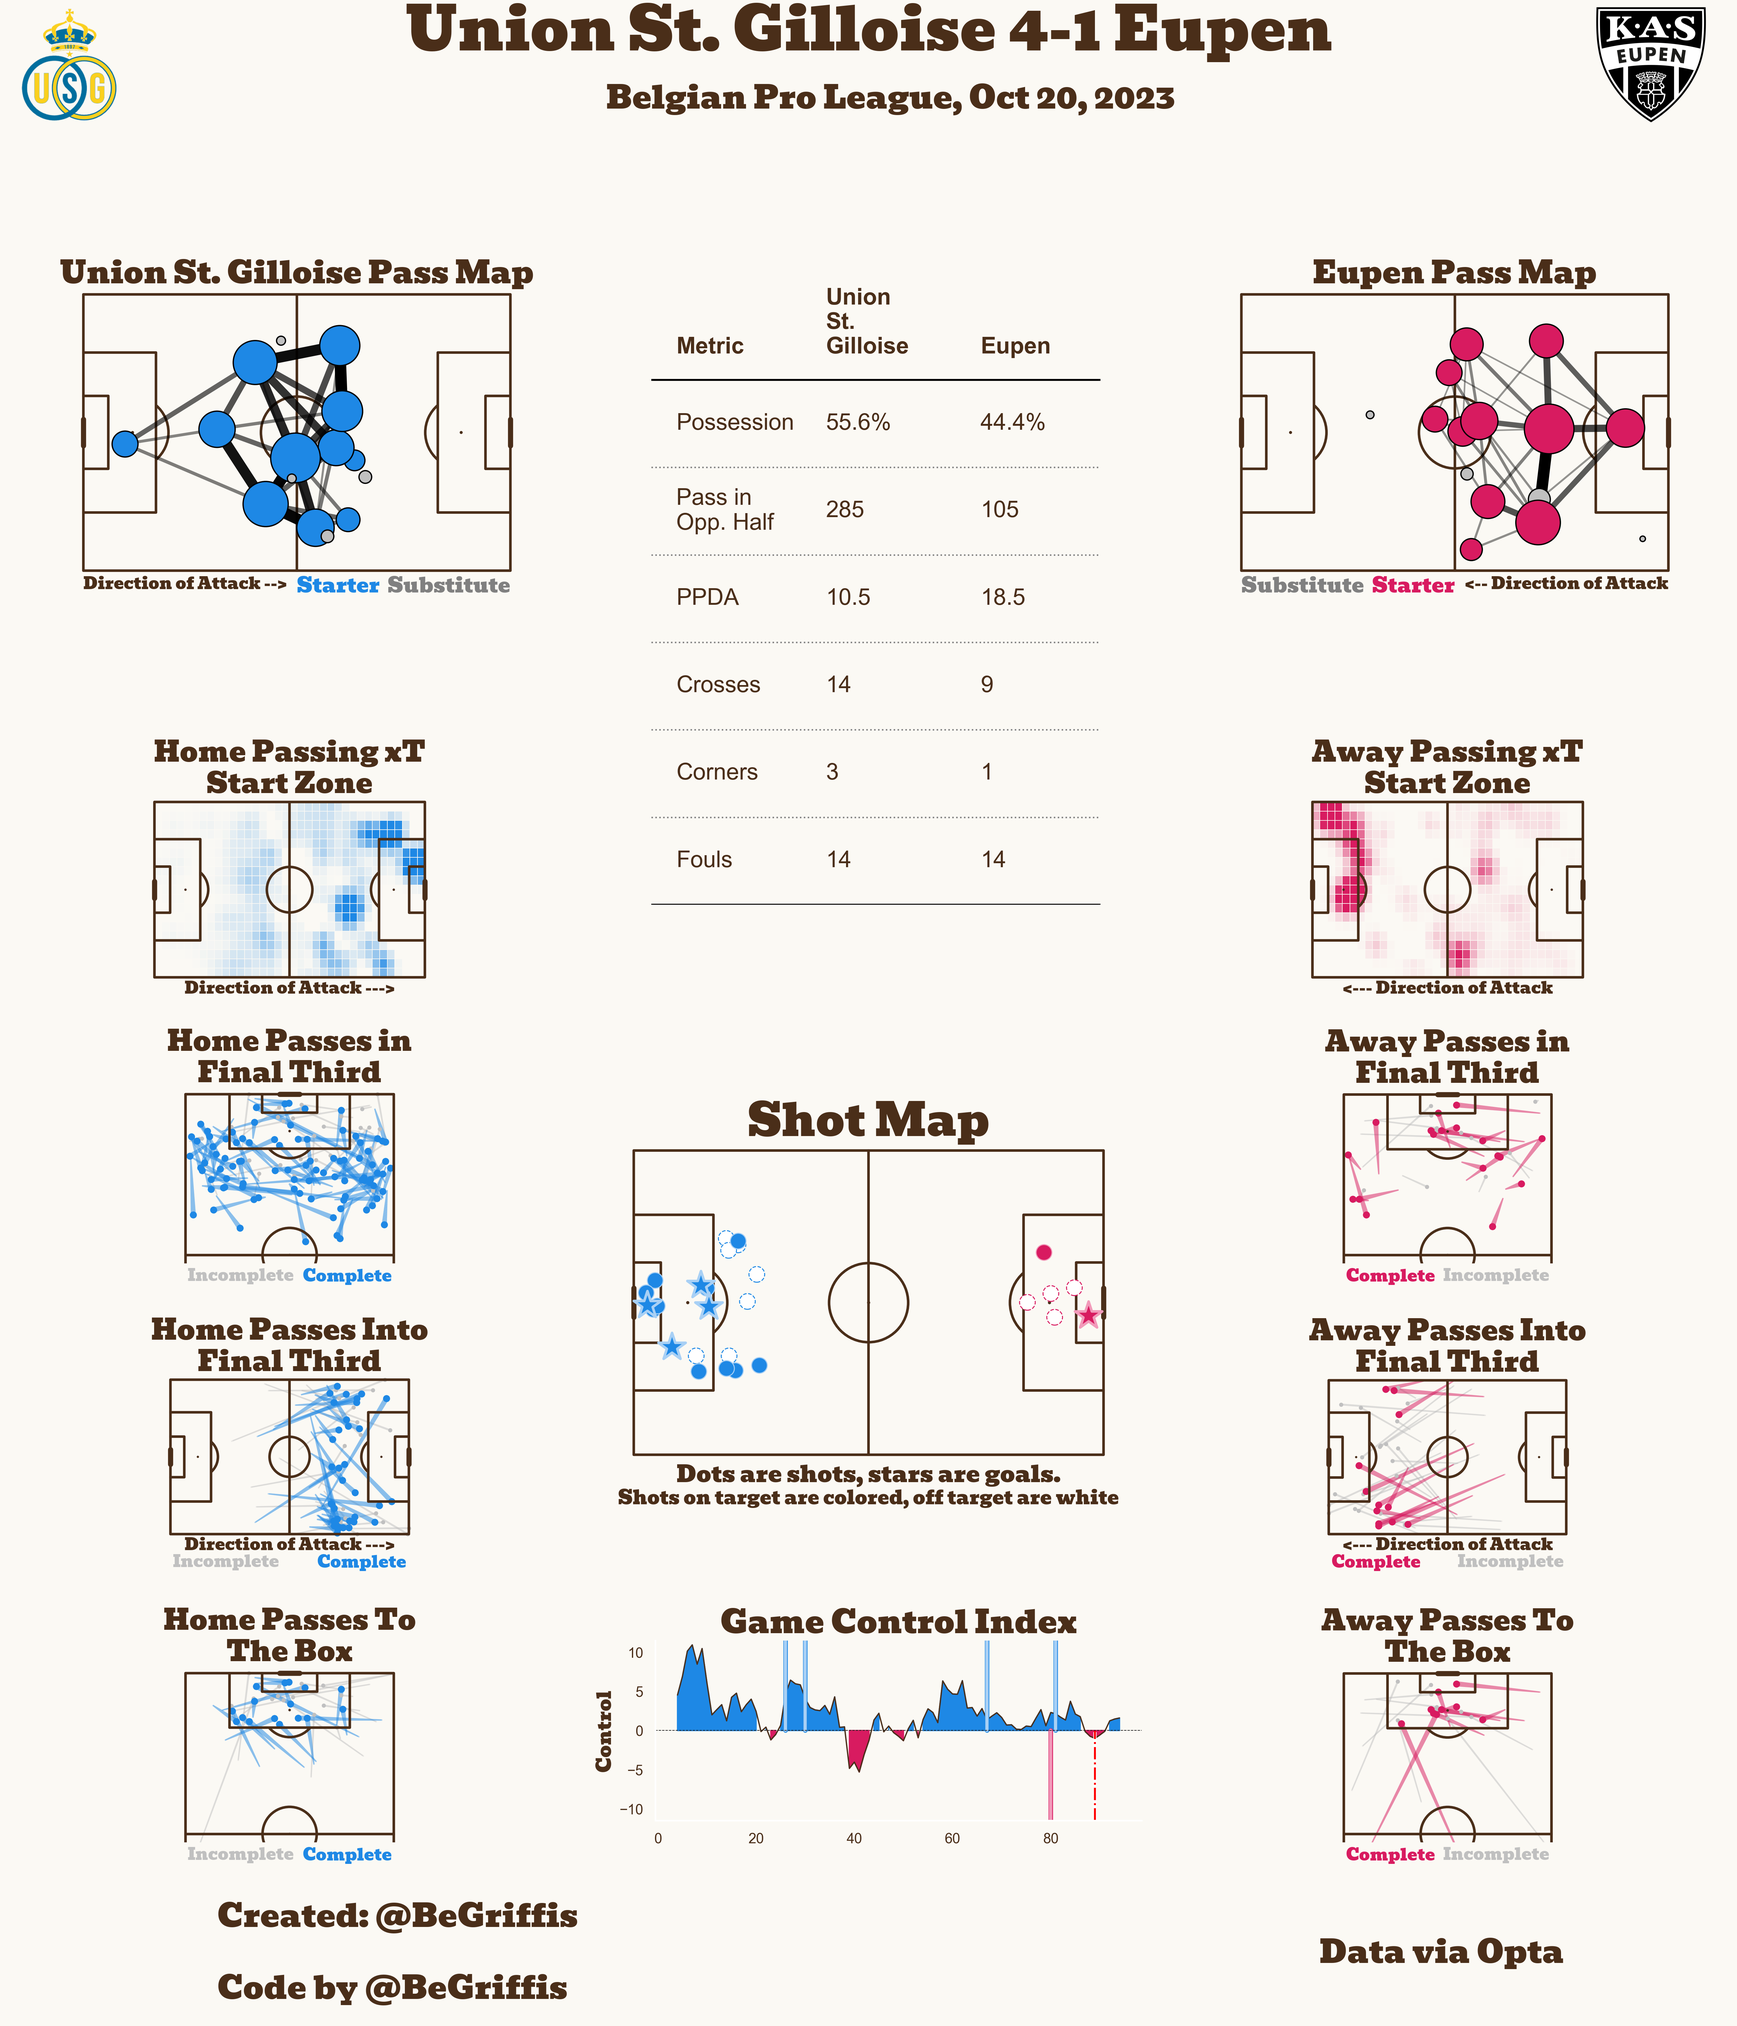

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 1882.8x1882.8 with 0 Axes>

<Figure size 1882.8x1882.8 with 0 Axes>

<Figure size 1255.2x1882.8 with 0 Axes>

<Figure size 1882.8x941.4 with 0 Axes>

<Figure size 5648.4x470.7 with 0 Axes>

<Figure size 5648.4x470.7 with 0 Axes>

In [5]:
whoscored_match_report(
    # The URL of the Whoscored match (detailed tournamnets only)
    url = 'https://www.whoscored.com/Matches/1735525/Live/Belgium-Jupiler-Pro-League-2023-2024-Union-St-Gilloise-Eupen',
    # The match name
    match = 'Union St. Gilloise 4-1 Eupen',
    
    # Home team name
    team_h = 'Union St. Gilloise',
    # Whoscored's ID for the home team (can find in the html slug of the team's page)
    teamId_h = 2647,
    
    # Away team name
    team_a = 'Eupen',
    # Away team ID
    teamId_a = 2166,
    
    # League name
    lg = 'Belgian Pro League',
    # Game date
    date = 'Oct 20, 2023',
    # Your signature
    sig = '@BeGriffis',
    
    # Location of your Chromedriver
    chrome_driver_loc = r'C:\Users\Ben\chromedriver.exe',
    # Where you want the data to download to
    data_download_loc = r'C:\Users\Ben\Matches',

    # Where you want the final image to export to
    img_save_loc = 'C:/Users/Ben/Downloads',
    # Path to home team's image
    home_img = f'C:/Users/Ben/Belgian Pro League/Union St. Gilloise.png',
    # Path to away team's image
    away_img = f'C:/Users/Ben/Belgian Pro League/Eupen.png'
)

In [1]:
def whoscored_match_report(url, match, team_h, teamId_h, team_a, teamId_a, lg, sig, date, chrome_driver_loc, data_download_loc, img_save_loc, home_img, away_img):
    import matplotlib.patheffects as path_effects
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import LinearSegmentedColormap
    import seaborn as sns
    import os
    from mplsoccer import VerticalPitch, FontManager
    from mplsoccer import Pitch
    from scipy.ndimage import gaussian_filter
    from PIL import Image
    import time
    import numpy as np
    import matplotlib
    from matplotlib.colors import to_rgba
    from matplotlib.colors import Normalize
    import tweepy
    import warnings
    warnings.filterwarnings("ignore")


    from selenium import webdriver
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    import clipboard
    from selenium.webdriver.common.keys import Keys

    options = webdriver.ChromeOptions()
    prefs = {"download.default_directory": data_download_loc}
    options.add_experimental_option("prefs",prefs)

    driver = webdriver.Chrome(chrome_driver_loc, options=options)
    driver.get(url)

    t = driver.page_source

    start = t.find("matchCentreData")+len('matchCentreData')+2
    end = t[t.find("matchCentreData"):].find('matchCentreEventTypeJson') + start - 30

    output = t[start:end]
    driver.close()

    driver = webdriver.Chrome(chrome_driver_loc, options=options)
    driver.get("https://konklone.io/json")
    input_css = 'body > section.json > div.areas > textarea'

    # Connecting to it with our driver
    input_area = driver.find_element(by=By.CSS_SELECTOR, value=input_css)

    # Set the sentence into the clipboard
    clipboard.copy(output)
    # Making sure that there is no previous text
    input_area.clear()
    # Pasting the copied sentence into the input_area
    input_area.send_keys(Keys.SHIFT, Keys.INSERT)

    # CSS of the download button
    click_css = 'body > section.csv > p > span.rendered > a.download'

    # Click it
    driver.find_element(by=By.CSS_SELECTOR, value=click_css).click()
    time.sleep(3)
    driver.close()

    os.chdir(data_download_loc)
    files = sorted(os.listdir(os.getcwd()), key=os.path.getmtime)
    df_base = pd.read_csv(f'{data_download_loc}/{files[-1]}')
    os.rename(f'{data_download_loc}/{files[-1]}', f'result {match}.csv')

    ####

    matplotlib.rcParams['figure.dpi'] = 300

    end_color_h = '#1E88E5'
    end_color_a = '#D81B60'
    kitline_h = '#a8d0f5'
    kitline_a = '#f29aba'

    name_h = 'Home'
    name_a = 'Away'

    URL = 'https://github.com/googlefonts/BevanFont/blob/main/fonts/ttf/Bevan-Regular.ttf?raw=true'
    fprop = FontManager(URL).prop


    ##############################################################################################
    ##############################################################################################
    ##############################################################################################
    df_base = df_base[df_base['period/displayName']!='PenaltyShootout'].reset_index(drop=True)

    type_cols = [col for col in df_base.columns if '/type/displayName' in col]


    df_base['endX'] = 0.0
    df_base['endY'] = 0.0
    for i in range(len(df_base)):
        df1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col == 'PassEndX':
                endx = df1.loc[:,'qualifiers/%i/value' %j].values[0]
                df_base['endX'][i] = float(endx)
            else:
                j +=1
        k = 0
        for k in range(len(type_cols)):
            col = df1[type_cols[k]].values[0]
            if col == 'PassEndY':
                endy = df1.loc[:,'qualifiers/%i/value' %k].values[0]
                df_base['endY'][i] = float(endy)
            else:
                k +=1

    df_base['Cross'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'Cross':
                df_base['Cross'][i] = 1
            else:
                j +=1

    df_base['Corner'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'CornerTaken':
                df_base['Corner'][i] = 1
            else:
                j +=1

    df_base['KeyPass'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'KeyPass':
                df_base['KeyPass'][i] = 1
            else:
                j +=1

    df_base['ShotAssist'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'ShotAssist':
                df_base['ShotAssist'][i] = 1
            else:
                j +=1

    df_base['FK'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'FreeKickTaken':
                df_base['FK'][i] = 1
            else:
                j +=1
    df_base['IFK'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'IndirectFreeKickTaken':
                df_base['IFK'][i] = 1
            else:
                j +=1
    df_base['GK'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'GoalKick':
                df_base['GK'][i] = 1
            else:
                j +=1
    df_base['ThrowIn'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'ThrowIn':
                df_base['ThrowIn'][i] = 1
            else:
                j +=1

    df_base['GoalMouthY'] = 0.0
    df_base['GoalMouthZ'] = 0.0
    for i in range(len(df_base)):            
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col == 'GoalMouthY':
                mouthy = df_base1.loc[:,'qualifiers/%i/value' %j].values[0]
                df_base['GoalMouthY'][i] = mouthy
            else:
                j +=1
        k = 0
        for k in range(len(type_cols)):
            col = df_base1[type_cols[k]].values[0]
            if col == 'GoalMouthZ':
                mouthz = df_base1.loc[:,'qualifiers/%i/value' %k].values[0]
                df_base['GoalMouthZ'][i] = mouthz
            else:
                k +=1
    try:            
        for i in range(len(df_base)):
            tid = df_base.teamId[i]
            if df_base.isOwnGoal[i] == True:
                if tid == teamId_h:
                    df_base.teamId[i] = teamId_a
                    df_base.x[i] = 100-df_base.x[i]
                    df_base.y[i] = 100-df_base.y[i]
                elif tid == teamId_a:
                    df_base.teamId[i] = teamId_h
    except:
        pass
    #####################

    df_base['RedCard'] = 0
    for i in range(len(df_base)):
        df_base1 = df_base.iloc[i:i+1,:]
        j = 0
        for j in range(len(type_cols)):
            col = df_base1[type_cols[j]].values[0]
            if col in ['SecondYellow','Red']:
                df_base['RedCard'][i] = 1
            else:
                j +=1

    ####################################################################################################
    ####################################################################################################
    ####################################################################################################

    df = df_base.copy()
    df = df[(df['Corner']==0) & (df['FK']==0) & (df['IFK']==0) & (df['GK']==0) & (df['ThrowIn']==0)]
    df = df[(df['type/displayName']=='Pass') & (df['outcomeType/value']==1)]

    xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None)
    xT = np.array(xT)
    xT_rows, xT_cols = xT.shape

    df['x1_bin_xT'] = pd.cut(df['x'], bins=xT_cols, labels=False)
    df['y1_bin_xT'] = pd.cut(df['y'], bins=xT_rows, labels=False)
    df['x2_bin_xT'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
    df['y2_bin_xT'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

    df['start_zone_value_xT'] = df[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    df['end_zone_value_xT'] = df[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    df['xT'] = df['end_zone_value_xT'] - df['start_zone_value_xT']

    colors = np.arctan2(df['xT'],[.01]*len(df))

    norm = Normalize()
    norm.autoscale(colors)

    ######################################################
    ######################################################
    ######################################################
    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=False)
    bins = (36, 19)

    maxstat = pitch.bin_statistic(df.x, df.y,
                                     df.xT, statistic='sum', bins=bins,)
    maxstatend = pitch.bin_statistic(df.endX, df.endY,
                                     df.xT, statistic='sum', bins=bins,)

    dfh = df[df['teamId']==teamId_h].reset_index(drop=True)

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=False)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4',end_color_h])
    # blank_hmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4','#fbf9f4'])

    bins = (36, 19)
    bs_heatmap = pitch.bin_statistic(df[df['teamId']==teamId_h].x, df[df['teamId']==teamId_h].y,
                                     values=df[df['teamId']==teamId_h].xT, statistic='sum', bins=bins,)
    bs_heatmap['statistic'] = gaussian_filter(bs_heatmap['statistic'], 1)

    ####################################################

    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=my_cmap, edgecolor='#fbf9f4', vmin=0, lw=.1,
                       vmax=np.percentile(maxstat['statistic'],95)
                      )

    ax.text(50, 102, "%s Passing xT\nStart Zone" %name_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(50,-2, 'Direction of Attack --->',
                      color='#4A2E19',va='top', ha='center',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Home xT By Zone Start.png", dpi = 300)
    plt.clf()
    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_h].copy().reset_index(drop=True)

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4',end_color_h])
    # blank_hmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4','#fbf9f4'])

    bins = (36, 19)
    bs_heatmap = pitch.bin_statistic(df[df['teamId']==teamId_h].endX, df[df['teamId']==teamId_h].endY,
                                     values=df[df['teamId']==teamId_h].xT, statistic='sum', bins=bins,)
    bs_heatmap['statistic'] = gaussian_filter(bs_heatmap['statistic'], 1)

    ####################################################

    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=my_cmap, edgecolor='#fbf9f4', vmin=0, lw=.1,
                       vmax=np.percentile(maxstatend['statistic'],95)
                      )

    ax.text(50, 102, "%s Passing xT\nEnd Zone" %name_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Home xT By Zone End.png", dpi = 300)
    plt.clf()
    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_a].copy().reset_index(drop=True)
    dfh.x = 100-dfh.x
    dfh.y = 100-dfh.y
    dfh.endX = 100-dfh.endX
    dfh.endY = 100-dfh.endY

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=False)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4',end_color_a])
    # blank_hmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4','#fbf9f4'])

    bins = (36, 19)
    bs_heatmap = pitch.bin_statistic(dfh[dfh['teamId']==teamId_a].x, dfh[dfh['teamId']==teamId_a].y,
                                     values=dfh[dfh['teamId']==teamId_a].xT, statistic='sum', bins=bins,)
    bs_heatmap['statistic'] = gaussian_filter(bs_heatmap['statistic'], 1)

    ####################################################

    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=my_cmap, edgecolor='#fbf9f4', vmin=0, lw=.1,
                       vmax=np.percentile(maxstat['statistic'],95)
                      )

    ax.text(50, 102, "%s Passing xT\nStart Zone" %name_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(50,-2, '<--- Direction of Attack',
                      color='#4A2E19',va='top', ha='center',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Away xT By Zone Start.png", dpi = 300)
    plt.clf()

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_a].copy().reset_index(drop=True)

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4',end_color_a])
    # blank_hmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fbf9f4','#fbf9f4'])

    bins = (36, 19)
    bs_heatmap = pitch.bin_statistic(df[df['teamId']==teamId_a].endX, df[df['teamId']==teamId_a].endY,
                                     values=df[df['teamId']==teamId_a].xT, statistic='sum', bins=bins,)
    bs_heatmap['statistic'] = gaussian_filter(bs_heatmap['statistic'], 1)

    ####################################################

    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=my_cmap, edgecolor='#fbf9f4', vmin=0, lw=.1,
                       vmax=np.percentile(maxstatend['statistic'],95)
                      )

    ax.text(50, 102, "%s Passing xT\nEnd Zone" %name_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Away xT By Zone End.png", dpi = 300)
    plt.clf()



    ####################################################################################################
    ####################################################################################################
    ####################################################################################################

    df = df_base.copy()
    # df = df[(df['Corner']==0) & (df['FK']==0) & (df['IFK']==0) & (df['GK']==0) & (df['ThrowIn']==0)]
    # df = df[df['type/displayName']=='Pass']
    df = df[df['type/displayName']=='Pass']

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_h].copy().reset_index(drop=True)

    df_final3_cmp = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==1) &
                       (dfh['endX']>=100-(100/3)) &
                       (dfh['x']<=100-(100/3))]
    df_final3_inc = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==0) &
                       (dfh['endX']>=100-(100/3)) &
                       (dfh['x']<=100-(100/3))]

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=False)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_final3_inc.x,
                       df_final3_inc.y,
                      df_final3_inc.endX,
                       df_final3_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_final3_cmp.x,
                       df_final3_cmp.y,
                      df_final3_cmp.endX,
                       df_final3_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_h, ax=ax)

    incdot = pitch.scatter(df_final3_inc.endX, df_final3_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_final3_cmp.endX, df_final3_cmp.endY,
                          s=20, c=end_color_h, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes Into\nFinal Third" %name_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(50,-2, 'Direction of Attack --->',
                      color='#4A2E19',va='top', ha='center',
                      fontproperties=fprop,fontsize=13)
    ax.text(99,-13, 'Complete',
                      color=end_color_h,va='top', ha='right',
                      fontproperties=fprop,fontsize=13)
    ax.text(1,-13, 'Incomplete',
                      color='silver',va='top', ha='left',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Home Final Third Passes.png", dpi = 300)
    plt.clf()

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_a].copy().reset_index(drop=True)
    dfh.x = 100-dfh.x
    dfh.y = 100-dfh.y
    dfh.endX = 100-dfh.endX
    dfh.endY = 100-dfh.endY

    df_final3_cmp = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==1) &
                       (dfh['endX']<=(100/3)) &
                       (dfh['x']>=(100/3))]
    df_final3_inc = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==0) &
                       (dfh['endX']<=(100/3)) &
                       (dfh['x']>=(100/3))]

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=False)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_final3_inc.x,
                       df_final3_inc.y,
                      df_final3_inc.endX,
                       df_final3_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_final3_cmp.x,
                       df_final3_cmp.y,
                      df_final3_cmp.endX,
                       df_final3_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_a, ax=ax)

    incdot = pitch.scatter(df_final3_inc.endX, df_final3_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_final3_cmp.endX, df_final3_cmp.endY,
                          s=20, c=end_color_a, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes Into\nFinal Third" %name_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(50,-2, '<--- Direction of Attack',
                      color='#4A2E19',va='top', ha='center',
                      fontproperties=fprop,fontsize=13)
    ax.text(1,-13, 'Complete',
                      color=end_color_a,va='top', ha='left',
                      fontproperties=fprop,fontsize=13)
    ax.text(99,-13, 'Incomplete',
                      color='silver',va='top', ha='right',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Away Final Third Passes.png", dpi = 300)
    plt.clf()

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_h].copy().reset_index(drop=True)

    df_box = dfh[(dfh['type/displayName']=='Pass') &
                 ((dfh['endX']>=100-17) &
                 (dfh['endY'].between(21.5,78.5))) 
                ]
    # df_box = df_box[(df_box['x']<=118.8) & ((df_box['y']<=79.2) | (df_box['y']>=.8))]
    df_box_cmp = df_box[df_box['outcomeType/value']==1]
    df_box_inc = df_box[df_box['outcomeType/value']==0]

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_box_inc.x,
                       df_box_inc.y,
                      df_box_inc.endX,
                       df_box_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_box_cmp.x,
                       df_box_cmp.y,
                      df_box_cmp.endX,
                       df_box_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_h, ax=ax)

    incdot = pitch.scatter(df_box_inc.endX, df_box_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_box_cmp.endX, df_box_cmp.endY,
                          s=20, c=end_color_h, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes To\nThe Box" %name_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(1,46, 'Complete',
                      color=end_color_h,va='top', ha='right',
                      fontproperties=fprop,fontsize=13)
    ax.text(99,46, 'Incomplete',
                      color='silver',va='top', ha='left',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Home Penalty Passes.png", dpi = 300)
    plt.clf()

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_a].copy().reset_index(drop=True)

    df_box = dfh[(dfh['type/displayName']=='Pass') &
                 ((dfh['endX']>=100-17) &
                 (dfh['endY'].between(21.5,78.5))) 
                ]
    # df_box = df_box[(df_box['x']<=118.8) & ((df_box['y']<=79.2) | (df_box['y']>=.8))]
    df_box_cmp = df_box[df_box['outcomeType/value']==1]
    df_box_inc = df_box[df_box['outcomeType/value']==0]

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_box_inc.x,
                       df_box_inc.y,
                      df_box_inc.endX,
                       df_box_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_box_cmp.x,
                       df_box_cmp.y,
                      df_box_cmp.endX,
                       df_box_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_a, ax=ax)

    incdot = pitch.scatter(df_box_inc.endX, df_box_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_box_cmp.endX, df_box_cmp.endY,
                          s=20, c=end_color_a, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes To\nThe Box" %name_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(99,46, 'Complete',
                      color=end_color_a,va='top', ha='left',
                      fontproperties=fprop,fontsize=13)
    ax.text(1,46, 'Incomplete',
                      color='silver',va='top', ha='right',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Away Penalty Passes.png", dpi = 300)
    plt.clf()


    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_h].copy().reset_index(drop=True)
    dfh = dfh[dfh['Corner']==0]
    dfh = dfh[dfh['ThrowIn']==0]

    df_final3_cmp = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==1) &
                       (dfh['x']>=100-(100/3))]
    df_final3_inc = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==0) &
                       (dfh['x']>=100-(100/3))]

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_final3_inc.x,
                       df_final3_inc.y,
                      df_final3_inc.endX,
                       df_final3_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_final3_cmp.x,
                       df_final3_cmp.y,
                      df_final3_cmp.endX,
                       df_final3_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_h, ax=ax)

    incdot = pitch.scatter(df_final3_inc.endX, df_final3_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_final3_cmp.endX, df_final3_cmp.endY,
                          s=20, c=end_color_h, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes in\nFinal Third" %name_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(1,46, 'Complete',
                      color=end_color_h,va='top', ha='right',
                      fontproperties=fprop,fontsize=13)
    ax.text(99,46, 'Incomplete',
                      color='silver',va='top', ha='left',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')
    fig.savefig(f"{img_save_loc}/Home Passes In Final Third.png", dpi = 300)
    plt.clf()

    ######################################################
    ######################################################
    ######################################################
    dfh = df[df['teamId']==teamId_a].copy().reset_index(drop=True)
    dfh = dfh[dfh['Corner']==0]
    dfh = dfh[dfh['ThrowIn']==0]

    # dfh.x = 100-dfh.x
    # dfh.y = 100-dfh.y
    # dfh.endX = 100-dfh.endX
    # dfh.endY = 100-dfh.endY

    df_final3_cmp = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==1) &
                       (dfh['x']>=100-(100/3))]
    df_final3_inc = dfh[(dfh['type/displayName']=='Pass') &
                       (dfh['outcomeType/value']==0) &
                       (dfh['x']>=100-(100/3))]

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=5, half=True)
    fig, ax = pitch.draw(figsize=(6.276, 6.276/2))
    fig.set_facecolor('#fbf9f4')

    incpass = pitch.lines(df_final3_inc.x,
                       df_final3_inc.y,
                      df_final3_inc.endX,
                       df_final3_inc.endY,
                          comet=True, alpha=.3,
                      lw=1.5, label='Incomplete',
                      color='silver', ax=ax)
    cmppass = pitch.lines(df_final3_cmp.x,
                       df_final3_cmp.y,
                      df_final3_cmp.endX,
                       df_final3_cmp.endY,
                          comet=True, alpha=.3,
                      lw=4, label='Complete',
                      color=end_color_a, ax=ax)

    incdot = pitch.scatter(df_final3_inc.endX, df_final3_inc.endY,
                          s=5, c='silver', zorder=2, ax=ax)
    cmpdot = pitch.scatter(df_final3_cmp.endX, df_final3_cmp.endY,
                          s=20, c=end_color_a, zorder=2, ax=ax)

    ax.text(50, 102, "%s Passes in\nFinal Third" %name_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=22)

    ax.text(99,46, 'Complete',
                      color=end_color_a,va='top', ha='left',
                      fontproperties=fprop,fontsize=13)
    ax.text(1,46, 'Incomplete',
                      color='silver',va='top', ha='right',
                      fontproperties=fprop,fontsize=13)

    fig=plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height
    fig.patch.set_facecolor('#fbf9f4')
    fig.savefig(f"{img_save_loc}/Away Passes In Final Third.png", dpi = 300)
    plt.clf()

    ####################################################################################################
    ####################################################################################################
    ####################################################################################################

    df2 = df_base.copy()
    # df2 = df2[(df2['x']!=0) & (df2['y']!=0)]
    df2 = df2.dropna(subset=['playerId']).reset_index(drop=True)

    starterlist = df2.playerId.unique().tolist()
    starterlist = [int(t) for t in starterlist]

    subdf = df2[df2['type/displayName']=='SubstitutionOn']
    sublist = subdf.playerId.unique().tolist()
    sublist = [int(t) for t in sublist]
    starterlist = [x for x in starterlist if x not in sublist]

    starterdf = pd.DataFrame({'id':starterlist,'pos':[1]*len(starterlist)})
    subdf = pd.DataFrame({'id':sublist,'pos':[5]*len(sublist)})
    p_dict = pd.concat([starterdf,subdf])

    # ###################################################################################


    df = df_base.copy()
    df["receiver"] = df["playerId"].shift(-1)

    df = df[df['teamId']==teamId_h]
    events = df[(df['type/displayName']=='Pass') & (df['outcomeType/value']==1) & (df['ThrowIn']==0)].copy().reset_index(drop=True)
    events_avg = df[(df['type/displayName']=='Pass') & (df['ThrowIn']==0)].copy().reset_index(drop=True)
    events = events.dropna(subset=['receiver'])

    # p_d = p_dict.copy()
    events['player_name'] = events['playerId']
    events_avg['player_name'] = events_avg['playerId']

    events['receiver_name'] = events['receiver']

    pass_cols = ['player_name', 'receiver']
    passes_formation = events
    location_cols = ['player_name', 'x', 'y']
    location_formation = events

    # average locations
    average_locs_and_count = (events.groupby('player_name')
                              .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count.columns = ['x', 'y', 'count']


    average_locs_and_countxxx = (events_avg.groupby('player_name')
                              .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_countxxx.columns = ['x', 'y', 'count']


    if average_locs_and_count.index[0] == '':
        average_locs_and_count = average_locs_and_count[1:]

    if average_locs_and_countxxx.index[0] == '':
        average_locs_and_countxxx = average_locs_and_countxxx[1:]


    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_formation['pos_max'] = (events[['player_name',
                                                    'receiver_name']]
                                   .max(axis='columns'))
    passes_formation['pos_min'] = (events[['player_name',
                                                    'receiver_name']]
                                   .min(axis='columns'))
    passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # # add on the location of each player so we have the start and end positions of the lines
    passes_between = passes_between.merge(average_locs_and_countxxx, left_on='pos_min', right_index=True)
    passes_between = passes_between.merge(average_locs_and_countxxx, left_on='pos_max', right_index=True,
                                          suffixes=['', '_end'])


    MAX_LINE_WIDTH = 18/2
    MAX_MARKER_SIZE = 3000/2

    passes_between = passes_between[passes_between['pass_count']>=5]

    passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                               MAX_LINE_WIDTH)
    average_locs_and_countxxx['marker_size'] = (average_locs_and_countxxx['count']
                                             / average_locs_and_countxxx['count'].max() * MAX_MARKER_SIZE)


    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('black'))
    color = np.tile(color, (len(passes_between), 1))
    c_transparency = passes_between.pass_count / passes_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19')
    fig, ax = pitch.draw(figsize=(6.276,6.276), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#fbf9f4")
    pass_lines = pitch.lines(passes_between.x, passes_between.y,
                             passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                             color=color, zorder=1, ax=ax)
    for i in range(len(average_locs_and_countxxx)):
        if p_dict[p_dict['id']==average_locs_and_countxxx.index[i]].pos.values[0] == 5:
            pass_nodes = pitch.scatter(average_locs_and_countxxx.iloc[i].x, average_locs_and_countxxx.iloc[i].y,
                                       s=average_locs_and_countxxx.iloc[i].marker_size,
                                       color='silver', edgecolors='black', linewidth=1, alpha=1, ax=ax)
        else:
            pass_nodes = pitch.scatter(average_locs_and_countxxx.iloc[i].x, average_locs_and_countxxx.iloc[i].y,
                                       s=average_locs_and_countxxx.iloc[i].marker_size,
                                       color=end_color_h, edgecolors='black', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_countxxx.iterrows():
        path_eff = [path_effects.Stroke(linewidth=1.5, foreground='#4A2E19'), path_effects.Normal()]
        try:
            pitch.annotate(p_d[p_d['id']==row.name].number.values[0], xy=(row.x, row.y),
                           c='white', va='center', path_effects=path_eff,
                           ha='center', size=10, weight='bold', ax=ax)
        except:
            pass



    ax.text(50, 102, "%s Pass Map" %team_h,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=24)
    ax.text(0,-2, 'Direction of Attack -->',
                      color='#4A2E19',va='top', ha='left',
                      fontproperties=fprop,fontsize=13)
    ax.text(50, -2, "Starter", va='top', ha='left', fontsize=16,
                        color=end_color_h,fontproperties=fprop)
    ax.text(100, -2, "Substitute", va='top', ha='right', fontsize=16,
                        color='grey',fontproperties=fprop)


    fig = plt.gcf()
    fig.set_size_inches(6.276,6.276) #length, height

    fig.savefig(f"{img_save_loc}/Home Heatmap.png", dpi = 300)
    plt.clf()


    ######################################################
    ######################################################
    ######################################################
    df = df_base.copy()
    df.x = 100-df.x
    df.y = 100-df.y

    df["receiver"] = df["playerId"].shift(-1)

    df = df[df['teamId']==teamId_a]
    events = df[(df['type/displayName']=='Pass') & (df['outcomeType/value']==1) & (df['ThrowIn']==0)].copy().reset_index(drop=True)
    events_avg = df[(df['type/displayName']=='Pass') & (df['ThrowIn']==0)].copy().reset_index(drop=True)
    events = events.dropna(subset=['receiver'])

    p_d = p_dict.copy()
    events['player_name'] = events['playerId']
    events_avg['player_name'] = events_avg['playerId']

    events['receiver_name'] = events['receiver']

    pass_cols = ['player_name', 'receiver']
    passes_formation = events
    location_cols = ['player_name', 'x', 'y']
    location_formation = events

    # average locations
    average_locs_and_count = (events.groupby('player_name')
                              .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count.columns = ['x', 'y', 'count']


    average_locs_and_countxxx = (events_avg.groupby('player_name')
                              .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_countxxx.columns = ['x', 'y', 'count']


    if average_locs_and_count.index[0] == '':
        average_locs_and_count = average_locs_and_count[1:]

    if average_locs_and_countxxx.index[0] == '':
        average_locs_and_countxxx = average_locs_and_countxxx[1:]


    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_formation['pos_max'] = (events[['player_name',
                                                    'receiver_name']]
                                   .max(axis='columns'))
    passes_formation['pos_min'] = (events[['player_name',
                                                    'receiver_name']]
                                   .min(axis='columns'))
    passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # # add on the location of each player so we have the start and end positions of the lines
    passes_between = passes_between.merge(average_locs_and_countxxx, left_on='pos_min', right_index=True)
    passes_between = passes_between.merge(average_locs_and_countxxx, left_on='pos_max', right_index=True,
                                          suffixes=['', '_end'])


    MAX_LINE_WIDTH = 18/2
    MAX_MARKER_SIZE = 3000/2

    passes_between = passes_between[passes_between['pass_count']>=5]

    passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                               MAX_LINE_WIDTH)
    average_locs_and_countxxx['marker_size'] = (average_locs_and_countxxx['count']
                                             / average_locs_and_countxxx['count'].max() * MAX_MARKER_SIZE)


    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('black'))
    color = np.tile(color, (len(passes_between), 1))
    c_transparency = passes_between.pass_count / passes_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19')
    fig, ax = pitch.draw(figsize=(6.276,6.276), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#fbf9f4")
    pass_lines = pitch.lines(passes_between.x, passes_between.y,
                             passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                             color=color, zorder=1, ax=ax)
    for i in range(len(average_locs_and_countxxx)):
        if p_dict[p_dict['id']==average_locs_and_countxxx.index[i]].pos.values[0] == 5:
            pass_nodes = pitch.scatter(average_locs_and_countxxx.iloc[i].x, average_locs_and_countxxx.iloc[i].y,
                                       s=average_locs_and_countxxx.iloc[i].marker_size,
                                       color='silver', edgecolors='black', linewidth=1, alpha=1, ax=ax)
        else:
            pass_nodes = pitch.scatter(average_locs_and_countxxx.iloc[i].x, average_locs_and_countxxx.iloc[i].y,
                                       s=average_locs_and_countxxx.iloc[i].marker_size,
                                       color=end_color_a, edgecolors='black', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_countxxx.iterrows():
        path_eff = [path_effects.Stroke(linewidth=1.5, foreground='#4A2E19'), path_effects.Normal()]
        try:
            pitch.annotate(p_d[p_d['id']==row.name].number.values[0], xy=(row.x, row.y),
                           c='white', va='center', path_effects=path_eff,
                           ha='center', size=10, weight='bold', ax=ax)
        except:
            pass



    ax.text(50, 102, "%s Pass Map" %team_a,
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=24)
    ax.text(100,-2, '<-- Direction of Attack',
                      color='#4A2E19',va='top', ha='right',
                      fontproperties=fprop,fontsize=13)
    ax.text(50, -2, "Starter", va='top', ha='right', fontsize=16,
                        color=end_color_a,fontproperties=fprop)
    ax.text(0, -2, "Substitute", va='top', ha='left', fontsize=16,
                        color='grey',fontproperties=fprop)


    fig = plt.gcf()
    fig.set_size_inches(6.276,6.276) #length, height

    fig.savefig(f"{img_save_loc}/Away Heatmap.png", dpi = 300)
    plt.clf()

    ####################################################################################################
    ####################################################################################################
    ####################################################################################################

    df = df_base.copy()

    dfh = df[df['teamId']==teamId_h].copy().reset_index(drop=True)
    dfa = df[df['teamId']==teamId_a].copy().reset_index(drop=True)

    ##### Possession
    h_pass_tot = dfh[(dfh['type/displayName']=='Pass')].copy().reset_index(drop=True)
    a_pass_tot = dfa[(dfa['type/displayName']=='Pass')].copy().reset_index(drop=True)
    h_poss = round(len(h_pass_tot)/(len(a_pass_tot)+len(h_pass_tot)) * 100,1)
    a_poss = 100-h_poss

    ##### Passes in Opp Half
    h_pass_f3 = dfh[(dfh['type/displayName']=='Pass') & (dfh['x']>50)].copy().reset_index(drop=True)
    a_pass_f3 = dfa[(dfa['type/displayName']=='Pass') & (dfa['x']>50)].copy().reset_index(drop=True)
    pass_opp_h = len(h_pass_f3)
    pass_opp_a = len(a_pass_f3)

    ##### PPDA
    # home
    df_focal = df[df['teamId']==teamId_h].copy().reset_index(drop=True)
    df_focal = df_focal[df_focal['x']>=33.333]
    df_opp = df[df['teamId']==teamId_a].copy().reset_index(drop=True)
    df_opp = df_opp[df_opp['x']<=66.666]
    df_focal_def = df_focal[(df_focal['type/value']==4) |  # Foul
                            (df_focal['type/value']==8) |  # Interception
                            (df_focal['type/value']==7)   # Tackle
                           ]
    df_opp_pass = df_opp[df_opp['type/displayName']=='Pass']
    h_ppda = len(df_opp_pass)/len(df_focal_def)

    # away
    df_focal = df[df['teamId']==teamId_a].copy().reset_index(drop=True)
    df_focal = df_focal[df_focal['x']>=33.333]
    df_opp = df[df['teamId']==teamId_h].copy().reset_index(drop=True)
    df_opp = df_opp[df_opp['x']<=66.666]
    df_focal_def = df_focal[(df_focal['type/value']==4) |  # Foul
                            (df_focal['type/value']==8) |  # Interception
                            (df_focal['type/value']==7)   # Tackle
                           ]
    df_opp_pass = df_opp[df_opp['type/displayName']=='Pass']
    a_ppda = len(df_opp_pass)/len(df_focal_def)

    ##### Corners
    corner_hh = dfh[(dfh['Corner']==1)].copy().reset_index(drop=True)
    corner_aa = dfa[(dfa['Corner']==1)].copy().reset_index(drop=True)
    corner_h = len(corner_hh)
    corner_a = len(corner_aa)


    ##### Crosses
    cross_h = len(dfh[(dfh['Cross']==1)].copy().reset_index(drop=True))
    cross_a = len(dfa[(dfa['Cross']==1)].copy().reset_index(drop=True))


    ##### Fouls
    fouls_h = dfh[(dfh['type/value']==4) & (dfh['outcomeType/value']==0)].copy().reset_index(drop=True)
    fouls_a = dfa[(dfa['type/value']==4) & (dfa['outcomeType/value']==0)].copy().reset_index(drop=True)


    #################
    ##### Table #####
    #################
    simple_stats = pd.DataFrame({'Metric':['Possession','Pass in\nOpp. Half','PPDA','Crosses', 'Corners', 'Fouls'],
                                 team_h.replace(" ","\n"):['%.1f%s' %(h_poss,'%'),
                                         '%i' %(pass_opp_h),
                                         '%.1f' %(h_ppda),
                                         '%i' %cross_h,
                                         '%i' %corner_h,
                                        f'{len(fouls_h)}'],
                                 team_a.replace(" ","\n"):['%.1f%s' %(a_poss,'%'),
                                         '%i' %(pass_opp_a),
                                         '%.1f' %(a_ppda),
                                         '%i' %cross_a,
                                         '%i' %corner_a,
                                        f'{len(fouls_a)}']})

    #############
    ############
    simple_stats = simple_stats[::-1]

    fig = plt.figure(figsize=(6.276,6.276*1.5), dpi=200)
    ax = plt.subplot()

    sns.set(rc={'axes.facecolor':'#fbf9f4', 'figure.facecolor':'#fbf9f4',
               'ytick.labelcolor':'#4A2E19', 'xtick.labelcolor':'#4A2E19'})
    ax.set_facecolor('#fbf9f4')
    ncols = len(simple_stats.columns.tolist())+1
    nrows = simple_stats.shape[0]

    ax.set_xlim(0, ncols + .5)
    ax.set_ylim(0, nrows + 1.5)

    positions = [0.25, 1.75, 3.3]

    columns = simple_stats.columns.tolist()

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if 'AaB' in column:
                text_label = f'{simple_stats[column].iloc[i]}'
                weight = 'bold'
            else:
                text_label = f'{simple_stats[column].iloc[i]}'
                weight = 'regular'
            ax.annotate(
                xy=(positions[j], i + .5),
                text = text_label,
                ha='left',
                va='center', color='#4A2E19',
                weight=weight,
                fontsize=18
            )


    # Add column names
    column_names = columns
    for index, c in enumerate(column_names):
            ax.annotate(
                xy=(positions[index], nrows + .25),
                text=column_names[index],
                ha='left',
                va='bottom',
                weight='bold', color='#4A2E19',fontsize=18
            )

    # Add dividing lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    ax.set_axis_off()

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    # -- Add nation axes
    ax_point_1 = DC_to_NFC([2.25, 0.25])
    ax_point_2 = DC_to_NFC([2.75, 0.75])
    ax_width = abs(ax_point_1[0] - ax_point_2[0])
    ax_height = abs(ax_point_1[1] - ax_point_2[1])


    fig = plt.gcf()
    fig.set_size_inches(6.276,6.276*1.5) #length, height
    fig.set_facecolor('#fbf9f4')

    fig.savefig(f"{img_save_loc}/Match Report Lineup.png", dpi = 300)

    plt.clf()

    ####################################################################################################
    ####################################################################################################
    ####################################################################################################

    pitch = Pitch(pitch_type='opta', pitch_color='#fbf9f4', line_color='#4A2E19', line_zorder=0, half=False)
    fig, ax = pitch.draw(figsize=(6.276, 6.276))
    fig.set_facecolor('#fbf9f4')

    df = df_base.copy()
    # for i in range(len(df)):
    #     if df['teamId'][i]==teamId_h:
    #         df.x = 100-df.x
    #         df.y = 100-df.y
    #         df.endX = 100-df.endX
    #         df.endY = 100-df.endY


    nongoals = df[(df['type/value']==13) | (df['type/value']==14) | (df['type/value']==15)].reset_index(drop=True)
    nongoals['Outcome'] = ''
    for i in range(len(nongoals)):
        gy = float(nongoals.GoalMouthY[i])
        gz = float(nongoals.GoalMouthZ[i])
        if gz > 42:
            nongoals.Outcome[i] = 'Off Target'
        if gy < 45.2:
            nongoals.Outcome[i] = 'Off Target'
        if gy > 54.8:
            nongoals.Outcome[i] = 'Off Target'

    goals = df[df['type/value']==16].reset_index(drop=True)

    scatter = pitch.scatter(100-nongoals[(nongoals['teamId']==teamId_h) & (nongoals['Outcome']=='Off Target')].x,
                            100-nongoals[(nongoals['teamId']==teamId_h) & (nongoals['Outcome']=='Off Target')].y,
                            ax=ax, s=150, color='white', ec=end_color_h, lw=.75, ls='--')
    scatter = pitch.scatter(100-nongoals[(nongoals['teamId']==teamId_h) & (nongoals['Outcome']=='')].x,
                            100-nongoals[(nongoals['teamId']==teamId_h) & (nongoals['Outcome']=='')].y,
                            ax=ax, s=150, color=end_color_h, ec=kitline_h, lw=.75)
    scatter = pitch.scatter(100-goals[goals['teamId']==teamId_h].x, 100-goals[goals['teamId']==teamId_h].y,
                            ax=ax, s=500, color=end_color_h, ec=kitline_h, marker='*', lw=2)

    scatter = pitch.scatter(nongoals[(nongoals['teamId']==teamId_a) & (nongoals['Outcome']=='Off Target')].x,
                            nongoals[(nongoals['teamId']==teamId_a) & (nongoals['Outcome']=='Off Target')].y,
                            ax=ax, s=150, color='white', ec=end_color_a, lw=.75, ls='--')
    scatter = pitch.scatter(nongoals[(nongoals['teamId']==teamId_a) & (nongoals['Outcome']=='')].x,
                            nongoals[(nongoals['teamId']==teamId_a) & (nongoals['Outcome']=='')].y,
                            ax=ax, s=150, color=end_color_a, ec=kitline_a, lw=.75)
    scatter = pitch.scatter(goals[goals['teamId']==teamId_a].x, goals[goals['teamId']==teamId_a].y,
                            ax=ax, s=500, color=end_color_a, ec=kitline_a, marker='*', lw=2)

    ax.text(50, 102, "Shot Map",
                      color='#4A2E19',
                      va='bottom', ha='center',
                      fontproperties=fprop,
                      fontsize=35)
    ax.text(50, -3, 'Dots are shots, stars are goals.',
            va='top', ha='center', fontsize=18, color='#4A2E19', fontproperties=fprop)
    ax.text(50, -11, 'Shots on target are colored, off target are white',
            va='top', ha='center', fontsize=15, color='#4A2E19', fontproperties=fprop)


    fig = plt.gcf()
    fig.set_size_inches(6.276,6.276) #length, height

    fig.savefig(f"{img_save_loc}/Match Report Shots.png", dpi = 300)

    plt.clf()

    # ######################################################################################################################
    # ###################################################################################################
    # #################################################################################

    ccc = 1.5

    fin_val = -2
    def_val = -1.5/ccc
    mid_val = -.5/ccc
    int_val = -1

    passval = 1.5
    shotval_in_val = 5
    shot_out_val = 2

    matplotlib.rcParams['figure.dpi'] = 300

    #####################################################################################################
    df = df_base.copy()

    df_pass = df[(df['type/displayName']=='Pass') & (df['outcomeType/value']==1)].reset_index(drop=True)
    df_def = df_pass[((df_pass['x']<=33.333) & (df_pass['endX']<=33.333))].reset_index(drop=True)
    df_fin = df_pass[((df_pass['x']>=66.666) & (df_pass['endX']<66.666))].reset_index(drop=True)
    df_int = df[df['type/value']==8].reset_index(drop=True)

    mid = df_pass[(df_pass['x'].between(33.333,66.666)) & (df_pass['endX'].between(33.333,66.666))
            ].reset_index(drop=True)

    goals_h = df[(df['type/value']==16) & (df['teamId']==teamId_h)].reset_index(drop=True)
    goals_a = df[(df['type/value']==16) & (df['teamId']==teamId_a)].reset_index(drop=True)
    red_card_h = df[(df['RedCard']==1) & (df['teamId']==teamId_h)].reset_index(drop=True)
    red_card_a = df[(df['RedCard']==1) & (df['teamId']==teamId_a)].reset_index(drop=True)

    df_def['val'] = def_val
    for i in range(len(df_def)):
        if df_def['teamId'][i] == teamId_a:
            df_def['val'][i] = -def_val

    df_fin['val'] = fin_val
    for i in range(len(df_fin)):
        if df_fin['teamId'][i] == teamId_a:
            df_fin['val'][i] = -fin_val

    mid['val'] = mid_val
    for i in range(len(mid)):
        if mid['teamId'][i] == teamId_a:
            mid['val'][i] = -mid_val

    df_int['val'] = int_val
    for i in range(len(df_int)):
        if df_int['teamId'][i] == teamId_a:
            df_int['val'][i] = -int_val

    def_fin = pd.concat([df_def,mid,df_fin,df_int])
    #####################################################################################################

    df = df_base.copy()

    df3 = df[(df['type/displayName']=='Pass') &
                       (df['outcomeType/value']==1) &
                       (df['endX']>=100-(100/3)) 
            ].reset_index(drop=True)

    shots = df_base[(df_base['type/value']==13) | (df_base['type/value']==14) | (df_base['type/value']==15) | (df_base['type/value']==16)].reset_index(drop=True)
    goals_h = df[(df['type/value']==16) & (df['teamId']==teamId_h)].reset_index(drop=True)
    goals_a = df[(df['type/value']==16) & (df['teamId']==teamId_a)].reset_index(drop=True)

    shots_in_box = shots[(shots['x']>=83.1) & (shots['y'].between(21.25,100-21.25))].reset_index(drop=True)
    shots_out_box = shots[~((shots['x']>=83.1) & (shots['y'].between(21.25,100-21.25)))].reset_index(drop=True)

    df3['val'] = passval
    for i in range(len(df3)):
        if df3['teamId'][i] == teamId_a:
            df3['val'][i] = -passval

    shots_in_box['val'] = shotval_in_val
    for i in range(len(shots_in_box)):
        if shots_in_box['teamId'][i] == teamId_a:
            shots_in_box['val'][i] = -shotval_in_val

    shots_out_box['val'] = shot_out_val
    for i in range(len(shots_out_box)):
        if shots_out_box['teamId'][i] == teamId_a:
            shots_out_box['val'][i] = -shot_out_val

    # df3 = df3.append(shots_in_box)
    # df3 = df3.append(shots_out_box)

    df3 = pd.concat([df3,shots_in_box,shots_out_box])

    def_fin = pd.concat([def_fin,df3])

    #####################################################################################################
    df3 = def_fin.reset_index(drop=True).copy()

    bins = np.arange(0,max(df['minute'])+1)
    # bins = [0,3,6,9,10,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,84,87,90,95,np.inf]
    df3['pressure_bins'] = pd.cut(df3['minute'], bins)
    df3 = df3.dropna(subset=['pressure_bins'])

    A = df3.groupby("pressure_bins", as_index=False)["val"].sum()

    A['3-Minute MA Pressure'] = float(0.0)
    arr = A['val'].values
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    while i < len(arr):
        period_average = ((1/5)*arr[i]) + ((1/5)*arr[(i-1)]) + ((1/5)*arr[(i-2)]) + ((1/5)*arr[(i-3)]) + ((1/5)*arr[(i-4)])

        moving_averages.append(period_average)
        i += 1

    for j in range(len(moving_averages)):
        A['3-Minute MA Pressure'].iloc[j] = moving_averages[j]
    for q in range(0,(5-1)):
        A['3-Minute MA Pressure'].iloc[q] = np.nan

    A['minute'] = np.arange(0,len(A))

    ax = sns.lineplot(x=A["minute"], y=A["3-Minute MA Pressure"], color='#4A2E19', lw=1)

    for i in range(len(goals_h)):
        ax.axvline(x=goals_h.minute[i], ymin=.5, color=end_color_h, ls='solid', lw=3.5)
        ax.axvline(x=goals_h.minute[i], ymin=.5, color=kitline_h, ls='solid', lw=2.5)
    for i in range(len(goals_a)):
        ax.axvline(x=goals_a.minute[i], ymax=.5, color=end_color_a, ls='solid', lw=3.5)
        ax.axvline(x=goals_a.minute[i], ymax=.5, color=kitline_a, ls='solid', lw=2.5)
    for i in range(len(red_card_h)):
        ax.axvline(x=red_card_h.minute[i], ymin=.5, color='white', ls='-.', lw=2.5)
        ax.axvline(x=red_card_h.minute[i], ymin=.5, color='red', ls='-.', lw=1.5)
    for i in range(len(red_card_a)):
        ax.axvline(x=red_card_a.minute[i], ymax=.5, color='white', ls='-.', lw=2.5)
        ax.axvline(x=red_card_a.minute[i], ymax=.5, color='red', ls='-.', lw=1.5)

    ax.set_xlabel(' ', color='#4A2E19')
    ax.set_ylabel('Control', color='#4A2E19', font_properties=fprop, fontsize=15)
    ax.set_title('Game Control Index', color='#4A2E19', font_properties=fprop, fontsize=25)

    ymax = max(abs(A['3-Minute MA Pressure'].dropna()).values.tolist())

    plt.ylim(-1*(ymax+(ymax*.05)), ymax+(ymax*.05))

    ax.fill_between(A["minute"], 0, A["3-Minute MA Pressure"],
                   where = A["3-Minute MA Pressure"] >=0,
                   color=end_color_h)
    ax.fill_between(A["minute"], 0, A["3-Minute MA Pressure"],
                   where = A["3-Minute MA Pressure"] <=0,
                   color=end_color_a)

    sns.despine()
    ax.grid(False)

    ax.set_facecolor('#fbf9f4')
    fig = plt.gcf()
    fig.patch.set_facecolor('#fbf9f4')

    plt.axhline(y=0, color='k', ls='--', lw=.5)


    fig = plt.gcf()
    fig.set_size_inches(6.276,6.276/2) #length, height

    fig.savefig(f"{img_save_loc}/Match Report Pressure.png", dpi=300)
    plt.clf()

    ######################################################################################################################
    ####################################################################################################
    ##################################################################################

    fig = plt.figure()

    plt.suptitle(match,
                fontproperties=fprop, fontsize=47, color='#4A2E19')
    plt.annotate("%s, %s" %(lg,date), xy=(.5,.25), ha='center', va='center',
                fontproperties=fprop, fontsize=25, color='#4A2E19')

    plt.axis('off')

    fig=plt.gcf()
    fig.set_size_inches(6.276*3,6.276/4) #length, height
    fig.patch.set_facecolor('#fbf9f4')

    image = Image.open(home_img)
    newax = fig.add_axes([-.36,.15,0.8,0.8], anchor='C', zorder=1) #[0.6,0.075,0.25,0.25] is base #0.65,0.04,0.2,0.2  #0.94,0.9,0.1,0.1                   
    newax.imshow(image)
    newax.axis('off')

    image = Image.open(away_img)
    newax = fig.add_axes([.55,.15,0.8,0.8], anchor='C', zorder=1) #[0.6,0.075,0.25,0.25] is base #0.65,0.04,0.2,0.2  #0.94,0.9,0.1,0.1                   
    newax.imshow(image)
    newax.axis('off')

    fig.savefig(f"{img_save_loc}/Match Report Team Pics.png", dpi = 300)
    plt.clf()
    ######################################################
    fig = plt.figure()

    plt.annotate(f'Created: {sig}\n\nCode by @BeGriffis', xy=(0,.5), ha='left', va='center',
                fontproperties=fprop, fontsize=25, color='#4A2E19')
    plt.annotate("Data via Opta", xy=(1,.5), ha='right', va='center',
                fontproperties=fprop, fontsize=25, color='#4A2E19')

    plt.axis('off')

    fig=plt.gcf()
    fig.set_size_inches(6.276*3,6.276/4) #length, height
    fig.patch.set_facecolor('#fbf9f4')


    fig.savefig(f"{img_save_loc}/Match Report Footer.png", dpi = 300)


    plt.clf()


    ######################################################################################################################
    ####################################################################################################
    ##################################################################################

    file16 = f'{img_save_loc}/Match Report Team Pics.png'
    file13 = f'{img_save_loc}/Match Report Lineup.png'
    file9 = f'{img_save_loc}/Home xT By Zone Start.png'
    file11 = f'{img_save_loc}/Home Passes In Final Third.png'
    file4 = f'{img_save_loc}/Home Final Third Passes.png'
    file5 = f'{img_save_loc}/Away Final Third Passes.png'
    file10 = f'{img_save_loc}/Away xT By Zone Start.png'
    file12 = f'{img_save_loc}/Away Passes In Final Third.png'
    file1 = f'{img_save_loc}/Home Heatmap.png'
    file2 = f'{img_save_loc}/Away Heatmap.png'
    file3 = f'{img_save_loc}/Match Report Shots.png'
    file14 = f'{img_save_loc}/Home Penalty Passes.png'
    file15 = f'{img_save_loc}/Away Penalty Passes.png'
    footer = f'{img_save_loc}/Match Report Footer.png'
    file17 = f'{img_save_loc}/Match Report Pressure.png'


    from PIL import Image

    def merge_4images(file1, file2, file3, file4, file5, file9, file10,
                      file11,file12,file13,file14,file15,file16,file17, footer):

        image1 = Image.open(file1)
        image2 = Image.open(file2)
        image3 = Image.open(file3)
        image4 = Image.open(file4)
        image5 = Image.open(file5)
        image9 = Image.open(file9)
        image10 = Image.open(file10)
        image11 = Image.open(file11)
        image12 = Image.open(file12)
        image13 = Image.open(file13)
        image14 = Image.open(file14)
        image15 = Image.open(file15)
        image16 = Image.open(file16)
        image17 = Image.open(file17)
        footer = Image.open(footer)

        (width1, height1) = image1.size
        (width2, height2) = image2.size
        (width3, height3) = image3.size
        (width4, height4) = image4.size
        (width5, height5) = image5.size
        (width9, height9) = image9.size
        (width10, height10) = image10.size
        (width11, height11) = image11.size
        (width12, height12) = image12.size
        (width13, height13) = image13.size
        (width14, height14) = image14.size
        (width15, height15) = image15.size
        (width16, height16) = image16.size
        (width17, height17) = image17.size
        (widthf, heightf) = footer.size

        result_width = width1*3
        result_height = height1+height9+height11+height9+height14+height16+heightf

        result = Image.new('RGB', (result_width, result_height))
        ##################################################################
        result.paste(im=image16, box=(0,0))  # Header Title

        result.paste(im=image13, box=(width1,0+height16))  # Lineuup
        result.paste(im=image3, box=(width1,height13+height16))  # Attack

        result.paste(im=image1, box=(0,0+height16))  # Home poss
        result.paste(im=image9, box=(0,height1+height16))  # Home loss
        result.paste(im=image11, box=(0,height1+height9+height16))  # Home Recovery
        result.paste(im=image4, box=(0,height1*2+height16))  # Home attacks

        result.paste(im=image2, box=(width13+width1,0+height16))  # Away poss
        result.paste(im=image10, box=(width13+width1,height1+height16))  # Away loss
        result.paste(im=image12, box=(width13+width1,height1+height9+height16))  # Away recovery
        result.paste(im=image5, box=(width13+width1,height1*2+height16))  # Away attacks

    #     result.paste(im=image17, box=(width1-300,height16+height13+height3))  # Twitter Footer
        result.paste(im=image17, box=(width1,height16+height13+height3))  # Twitter Footer

        result.paste(im=image14, box=(0,height1+height9+height2+height16))  # Home def duel
        result.paste(im=image15, box=(width13+width1,height1+height9+height2+height16))  # Away def duel

        result.paste(im=footer, box=(0,height16+height13+height3+height14-1))  # Twitter Footer
        ##################################################################

        return result
    output=merge_4images(file1, file2, file3, file4, file5, file9,
                  file10, file11,file12,file13,file14,file15,file16,file17, footer)
    output.save(f'{img_save_loc}/{match}.png')
    im = Image.open(f'{img_save_loc}/{match}.png')
    size = int(round(im.size[0]/3.25,0)), int(round(im.size[1]/3.25,0))
    im_resized = im.resize(size, Image.ANTIALIAS)
    im_resized.save(f'{img_save_loc}/{match}.png')

    plt.clf()
    os.remove(f'{img_save_loc}/Match Report Team Pics.png')
    os.remove(f'{img_save_loc}/Match Report Lineup.png')
    os.remove(f'{img_save_loc}/Home xT By Zone Start.png')
    os.remove(f'{img_save_loc}/Home xT By Zone End.png')
    os.remove(f'{img_save_loc}/Away xT By Zone End.png')
    os.remove(f'{img_save_loc}/Home Passes In Final Third.png')
    os.remove(f'{img_save_loc}/Home Final Third Passes.png')
    os.remove(f'{img_save_loc}/Away Final Third Passes.png')
    os.remove(f'{img_save_loc}/Away xT By Zone Start.png')
    os.remove(f'{img_save_loc}/Away Passes In Final Third.png')
    os.remove(f'{img_save_loc}/Home Heatmap.png')
    os.remove(f'{img_save_loc}/Away Heatmap.png')
    os.remove(f'{img_save_loc}/Match Report Shots.png')
    os.remove(f'{img_save_loc}/Home Penalty Passes.png')
    os.remove(f'{img_save_loc}/Away Penalty Passes.png')
    os.remove(f'{img_save_loc}/Match Report Footer.png')
    os.remove(f'{img_save_loc}/Match Report Pressure.png')

    return im_resized



In [ ]:
nongoals.GoalMouthZ[i]